In [1]:
import scanpy as sc
data_dir = '../../dataset/HiT_CA4_DGC_filtered.h5ad'
adata = sc.read_h5ad(data_dir)

In [2]:
print(adata.X)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 190662798 stored elements and shape (56367, 18752)>
  Coords	Values
  (0, 10785)	5.0
  (0, 13830)	3.0
  (0, 9792)	1.0
  (0, 361)	3.0
  (0, 11996)	31.0
  (0, 11375)	1.0
  (0, 11866)	1.0
  (0, 1413)	1.0
  (0, 3893)	5.0
  (0, 13348)	3.0
  (0, 8872)	3.0
  (0, 1239)	2.0
  (0, 17254)	5.0
  (0, 11793)	4.0
  (0, 9121)	1.0
  (0, 1474)	2.0
  (0, 10369)	2.0
  (0, 9327)	1.0
  (0, 11060)	1.0
  (0, 10047)	1.0
  (0, 7166)	1.0
  (0, 7878)	2.0
  (0, 16110)	3.0
  (0, 6831)	1.0
  (0, 9236)	3.0
  :	:
  (56366, 17768)	4.0
  (56366, 8372)	1.0
  (56366, 1045)	2.0
  (56366, 17383)	1.0
  (56366, 1783)	5.0
  (56366, 13757)	3.0
  (56366, 14311)	3.0
  (56366, 4387)	1.0
  (56366, 16352)	4.0
  (56366, 103)	2.0
  (56366, 12074)	1.0
  (56366, 10922)	1.0
  (56366, 8267)	1.0
  (56366, 6187)	2.0
  (56366, 8250)	1.0
  (56366, 17441)	1.0
  (56366, 4186)	1.0
  (56366, 212)	1.0
  (56366, 16186)	1.0
  (56366, 10277)	1.0
  (56366, 9604)	1.0
  (56366, 1530)	3.0
  (5

In [3]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import lightning.pytorch as pl
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPBarlowTwins
from self_supervision.estimator.cellnet import EstimatorAutoEncoder

# 设置你的 .ckpt 文件路径
ckpt_path = "../../sc_pretrained/Pretrained Models/BarlowTwins.ckpt"

# 模型参数
units_encoder = [512, 512, 256, 256, 64]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 如果没有实际数据路径，可以设置为None

# 加载预训练模型
estim.model = MLPBarlowTwins(
        gene_dim=19331,  # 根据你的数据调整
        batch_size=128,  # 根据你的需要调整
        units_encoder=units_encoder,
        CHECKPOINT_PATH=ckpt_path
    )


estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)
estim.model

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


MLPBarlowTwins(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (inner_model): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=25

In [4]:
# 加载 checkpoint
checkpoint = torch.load(ckpt_path)
estim.model.inner_model.load_state_dict({k.replace('backbone.', ''): v for k, v in checkpoint.items() if 'backbone' in k})


<All keys matched successfully>

In [5]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

11

In [6]:
import pandas as pd
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
var_df

,feature_id,feature_name
0,ENSG00000186092,OR4F5
1,ENSG00000284733,OR4F29
2,ENSG00000284662,OR4F16
3,ENSG00000187634,SAMD11
4,ENSG00000188976,NOC2L
...,...,...
19326,ENSG00000288702,UGT1A3
19327,ENSG00000288705,UGT1A5
19328,ENSG00000182484,WASH6P
19329,ENSG00000288622,PDCD6-AHRR


In [7]:
all_genes = var_df['feature_name'].tolist()
all_genes

['OR4F5',
 'OR4F29',
 'OR4F16',
 'SAMD11',
 'NOC2L',
 'KLHL17',
 'PLEKHN1',
 'PERM1',
 'HES4',
 'ISG15',
 'AGRN',
 'RNF223',
 'C1orf159',
 'TTLL10',
 'TNFRSF18',
 'TNFRSF4',
 'SDF4',
 'B3GALT6',
 'C1QTNF12',
 'UBE2J2',
 'SCNN1D',
 'ACAP3',
 'PUSL1',
 'INTS11',
 'CPTP',
 'TAS1R3',
 'DVL1',
 'MXRA8',
 'AURKAIP1',
 'CCNL2',
 'MRPL20',
 'ANKRD65',
 'TMEM88B',
 'VWA1',
 'ATAD3C',
 'ATAD3B',
 'ATAD3A',
 'TMEM240',
 'SSU72',
 'FNDC10',
 'MIB2',
 'MMP23B',
 'CDK11B',
 'SLC35E2B',
 'CDK11A',
 'NADK',
 'GNB1',
 'CALML6',
 'TMEM52',
 'CFAP74',
 'GABRD',
 'PRKCZ',
 'FAAP20',
 'SKI',
 'MORN1',
 'RER1',
 'PEX10',
 'PLCH2',
 'PANK4',
 'HES5',
 'TNFRSF14',
 'PRXL2B',
 'MMEL1',
 'TTC34',
 'ACTRT2',
 'PRDM16',
 'ARHGEF16',
 'MEGF6',
 'TPRG1L',
 'WRAP73',
 'TP73',
 'CCDC27',
 'SMIM1',
 'LRRC47',
 'CEP104',
 'DFFB',
 'C1orf174',
 'AJAP1',
 'NPHP4',
 'KCNAB2',
 'CHD5',
 'RPL22',
 'RNF207',
 'ICMT',
 'HES3',
 'GPR153',
 'ACOT7',
 'HES2',
 'ESPN',
 'TNFRSF25',
 'PLEKHG5',
 'NOL9',
 'TAS1R1',
 'ZBTB48',
 'KLH

In [8]:
adata.var['gene_name']=adata.var.index
adata.var['gene_name']

feature
TFAP2A      TFAP2A
DGCR2        DGCR2
ZNF703      ZNF703
MUL1          MUL1
TRMT61B    TRMT61B
            ...   
LAMTOR1    LAMTOR1
LRRC56      LRRC56
WFS1          WFS1
P2RX1        P2RX1
FOSB          FOSB
Name: gene_name, Length: 18752, dtype: category
Categories (59236, object): ['5S_rRNA_ENSG00000276861', '5S_rRNA_ENSG00000277411', '5S_rRNA_ENSG00000277488', '5S_rRNA_ENSG00000278457', ..., 'hsa-mir-1253', 'hsa-mir-423', 'hsa-mir-8069-1', 'snoZ196']

In [9]:
import numpy as np
# 初始化一个新的数据矩阵，形状为 (adata.X.shape[0], len(all_genes))，填充为零
new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)


In [10]:
existing_genes = adata.var['gene_name']
existing_genes

feature
TFAP2A      TFAP2A
DGCR2        DGCR2
ZNF703      ZNF703
MUL1          MUL1
TRMT61B    TRMT61B
            ...   
LAMTOR1    LAMTOR1
LRRC56      LRRC56
WFS1          WFS1
P2RX1        P2RX1
FOSB          FOSB
Name: gene_name, Length: 18752, dtype: category
Categories (59236, object): ['5S_rRNA_ENSG00000276861', '5S_rRNA_ENSG00000277411', '5S_rRNA_ENSG00000277488', '5S_rRNA_ENSG00000278457', ..., 'hsa-mir-1253', 'hsa-mir-423', 'hsa-mir-8069-1', 'snoZ196']

In [11]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes


匹配的基因数量: 18752
匹配的基因列表: {'dnajc14', 'c2cd6', 'rabggta', 'leprotl1', 'spg21', 'ctdspl2', 'ro60', 'slc26a8', 'gdf2', 'pde6d', 'dnlz', 'snx21', 'tnr', 'spata31d1', 'plekha8', 'znf337', 'znf536', 'nwd2', 'gabrb1', 'tmprss4', 'scgb1d1', 'loxhd1', 'smim43', 'bmp4', 'trarg1', 'nploc4', 'igfbp6', 'slc35b4', 'psma8', 'gli4', 'bhlha9', 'ctbp2', 'tril', 'abca4', 'rgs7', 'cirbp', 'iqch', 'krtap6-2', 'pamr1', 'pou2f2', 'atp8b2', 'pcdhgb6', 'bcl2l13', 'ccl2', 'bax', 'nrk', 'ptgs1', 'shoc1', 'eif2s2', 'cited1', 'rangap1', 'irak3', 'chia', 'ankrd61', 'scygr7', 'znf217', 'sgip1', 'nfatc2ip', 'kctd17', 'chst8', 'zp2', 'ccdc110', 'efr3b', 'epha4', 'krt86', 'plekhn1', 'fsd1', 'prss27', 'klhl7', 'pxk', 'iqcf6', 'znf451', 'calhm4', 'atpsckmt', 'ccnd3', 'frat2', 'bricd5', 'pgf', 'lrrtm3', 'col9a1', 'pan2', 'foxred2', 'abhd11', 'ecscr', 'sp5', 'ddx10', 'pigs', 'fn3krp', 'aldh18a1', 'tph1', 'sra1', 'mphosph6', 'tpp2', 'ctnna3', 'dus2', 'pnma2', 'camk1g', 'myo5c', 'znf419', 'urgcp', 'acp7', 'tmem247', 'mgat1', 

set()

In [12]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
gene_to_index

{'or4f5': 0,
 'or4f29': 1,
 'or4f16': 2,
 'samd11': 3,
 'noc2l': 4,
 'klhl17': 5,
 'plekhn1': 6,
 'perm1': 7,
 'hes4': 8,
 'isg15': 9,
 'agrn': 10,
 'rnf223': 11,
 'c1orf159': 12,
 'ttll10': 13,
 'tnfrsf18': 14,
 'tnfrsf4': 15,
 'sdf4': 16,
 'b3galt6': 17,
 'c1qtnf12': 18,
 'ube2j2': 19,
 'scnn1d': 20,
 'acap3': 21,
 'pusl1': 22,
 'ints11': 23,
 'cptp': 24,
 'tas1r3': 25,
 'dvl1': 26,
 'mxra8': 27,
 'aurkaip1': 28,
 'ccnl2': 29,
 'mrpl20': 30,
 'ankrd65': 31,
 'tmem88b': 32,
 'vwa1': 33,
 'atad3c': 34,
 'atad3b': 35,
 'atad3a': 36,
 'tmem240': 37,
 'ssu72': 38,
 'fndc10': 39,
 'mib2': 40,
 'mmp23b': 41,
 'cdk11b': 42,
 'slc35e2b': 43,
 'cdk11a': 44,
 'nadk': 45,
 'gnb1': 46,
 'calml6': 47,
 'tmem52': 48,
 'cfap74': 49,
 'gabrd': 50,
 'prkcz': 51,
 'faap20': 52,
 'ski': 53,
 'morn1': 54,
 'rer1': 55,
 'pex10': 56,
 'plch2': 57,
 'pank4': 58,
 'hes5': 59,
 'tnfrsf14': 60,
 'prxl2b': 61,
 'mmel1': 62,
 'ttc34': 63,
 'actrt2': 64,
 'prdm16': 65,
 'arhgef16': 66,
 'megf6': 67,
 'tprg1l': 68

In [13]:
only_in_all_genes = all_genes_set - adata_genes_set

only_in_adata_genes = adata_genes_set - all_genes_set

# 输出结果
print(f"仅在 all_genes 中存在的基因数量: {len(only_in_all_genes)}")
print(f"仅在 all_genes 中存在的基因: {only_in_all_genes}")

print(f"仅在 adata_genes 中存在的基因数量: {len(only_in_adata_genes)}")
print(f"仅在 adata_genes 中存在的基因: {only_in_adata_genes}")


仅在 all_genes 中存在的基因数量: 579
仅在 all_genes 中存在的基因: {'atp6v1g2-ddx39b', 'c17orf64', 'or4f3', 'spata31a5', 'poc1b-galnt4', 'tbc1d3e', 'notch2nlb', 'znf720', 'nanogp8', 'fam90a18p', 'znf705b', 'eef1aknmt', 'arntl2', 'c1orf189', 'rbm14-rbm4', 'usp17l28', 'pramef7', 'ten1-cdk3', 'spdye9', 'gatd3a', 'rbmy1e', 'foxd4l6', 'atf7-npff', 'fam243b', 'ubd', 'lmln2', 'aqp12a', 'c9orf16', 'ccdc173', 'hspe1-mob4', 'mkks', 'gdf1', 'actl10', 'gage2e', 'stimate-mustn1', 'tvp23c-cdrt4', 'rgpd4', 'golga6l1', 'f10', 'pramef27', 'atp5mf-ptcd1', 'fam90a9p', 'kcne1b', 'wdr61', 'rbmy1f', 'usp17l22', 'tmem256-plscr3', 'trim49d2', 'ssu72p3', 'tptep2-csnk1e', 'usp17l29', 'fam71d', 'c16orf72', 'h2aw', 'st20-mthfs', 'slc9a3r1', 'cntnap3c', 'poteb2', 'gimap1-gimap5', 'bpy2b', 'or2a42', 'c12orf45', 'or4f29', 'cyhr1', 'sys1-dbndd2', 'ube2f-scly', 'ctage9', 'gage12c', 'c10orf99', 'rtel1-tnfrsf6b', 'coro7-pam16', 'ctage6', 'ifna1', 'spty2d1os', 'hsfy2', 'prr20a', 'or11h12', 'rbak-rbakdn', 'ramacl', 'c12orf65', 'f3', 'frg2b'

In [14]:
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

In [15]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42
X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)



# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

cuda


MLPBarlowTwins(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (inner_model): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.0, inplace=False)
    (9): Linear(in_features=256, out_features=25

In [16]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.inner_model.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻最后两层
for param in list(estim.model.inner_model.parameters())[-5:]:
    param.requires_grad = True

In [17]:
from torch.optim import AdamW
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [18]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.inner_model(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.inner_model(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [19]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 0.07992983689207397, Validation Loss: 0.00481576682774284
Validation loss improved to 0.00481576682774284, resetting patience.


Epoch 2, Train Loss: 0.00392348178319801, Validation Loss: 0.001729200529566629
Validation loss improved to 0.001729200529566629, resetting patience.


Epoch 3, Train Loss: 0.0035897339918838306, Validation Loss: 0.0013670305831795697
Validation loss improved to 0.0013670305831795697, resetting patience.


Epoch 4, Train Loss: 0.003195638836584079, Validation Loss: 0.001538346854947271
No improvement in validation loss. Patience counter: 1/20


Epoch 5, Train Loss: 0.003198027065635337, Validation Loss: 0.0023334324920251132
No improvement in validation loss. Patience counter: 2/20


Epoch 6, Train Loss: 0.002638775602998973, Validation Loss: 0.0009748671584373424
Validation loss improved to 0.0009748671584373424, resetting patience.


Epoch 7, Train Loss: 0.0028804063641270387, Validation Loss: 0.0012526100684077228
No improvement in validation loss. Patience counter: 1/20


Epoch 8, Train Loss: 0.002677363061493422, Validation Loss: 0.0012650038717304177
No improvement in validation loss. Patience counter: 2/20


Epoch 9, Train Loss: 0.00245712078070596, Validation Loss: 0.00043400947459358303
Validation loss improved to 0.00043400947459358303, resetting patience.


Epoch 10, Train Loss: 0.0025147224740384912, Validation Loss: 0.0006624585045905568
No improvement in validation loss. Patience counter: 1/20


Epoch 11, Train Loss: 0.002354977879053656, Validation Loss: 0.0017907413779295297
No improvement in validation loss. Patience counter: 2/20


Epoch 12, Train Loss: 0.0022265908168468103, Validation Loss: 0.0010243268356026052
No improvement in validation loss. Patience counter: 3/20


Epoch 13, Train Loss: 0.0023041686744390178, Validation Loss: 0.00034687117539448735
No improvement in validation loss. Patience counter: 4/20


Epoch 14, Train Loss: 0.0015899466576305842, Validation Loss: 0.0004590609747103725
No improvement in validation loss. Patience counter: 5/20


Epoch 15, Train Loss: 0.0025421021585531204, Validation Loss: 0.0014090830528172109
No improvement in validation loss. Patience counter: 6/20


Epoch 16, Train Loss: 0.002515556905237442, Validation Loss: 0.0005342272653699672
No improvement in validation loss. Patience counter: 7/20


Epoch 17, Train Loss: 0.0023316845307240963, Validation Loss: 0.0008162720134432267
No improvement in validation loss. Patience counter: 8/20


Epoch 18, Train Loss: 0.0026970589521078795, Validation Loss: 0.0008096948493864568
No improvement in validation loss. Patience counter: 9/20


Epoch 19, Train Loss: 0.001578490448032411, Validation Loss: 0.0005665728002990797
No improvement in validation loss. Patience counter: 10/20


Epoch 20, Train Loss: 0.0014398381470566229, Validation Loss: 0.000742189513552311
No improvement in validation loss. Patience counter: 11/20


Epoch 21, Train Loss: 0.00212948111154534, Validation Loss: 0.0018077860785619558
No improvement in validation loss. Patience counter: 12/20


Epoch 22, Train Loss: 0.0022917459036703143, Validation Loss: 0.0018768369123356376
No improvement in validation loss. Patience counter: 13/20


Epoch 23, Train Loss: 0.002765587188808146, Validation Loss: 0.0007858540379110404
No improvement in validation loss. Patience counter: 14/20


Epoch 24, Train Loss: 0.0017488039237288926, Validation Loss: 0.0002824118444876339
Validation loss improved to 0.0002824118444876339, resetting patience.


Epoch 25, Train Loss: 0.0012092995155244992, Validation Loss: 0.00025147631280655766
No improvement in validation loss. Patience counter: 1/20


Epoch 26, Train Loss: 0.0016000845914033008, Validation Loss: 0.010155928255278298
No improvement in validation loss. Patience counter: 2/20


Epoch 27, Train Loss: 0.0020418666534693375, Validation Loss: 0.0008775741938795513
No improvement in validation loss. Patience counter: 3/20


Epoch 28, Train Loss: 0.002755937103382337, Validation Loss: 0.0035682509137781883
No improvement in validation loss. Patience counter: 4/20


Epoch 29, Train Loss: 0.0016025474964981054, Validation Loss: 0.0005469381923165798
No improvement in validation loss. Patience counter: 5/20


Epoch 30, Train Loss: 0.001275339599321664, Validation Loss: 0.0005170261915533155
No improvement in validation loss. Patience counter: 6/20


Epoch 31, Train Loss: 0.0014012315004634864, Validation Loss: 0.0003341651535139991
No improvement in validation loss. Patience counter: 7/20


Epoch 32, Train Loss: 0.001659475277172799, Validation Loss: 0.0020177885079878007
No improvement in validation loss. Patience counter: 8/20


Epoch 33, Train Loss: 0.0015790782560449997, Validation Loss: 0.0006866904245759828
No improvement in validation loss. Patience counter: 9/20


Epoch 34, Train Loss: 0.0011616210937434993, Validation Loss: 0.0009470909150076661
No improvement in validation loss. Patience counter: 10/20


Epoch 35, Train Loss: 0.00098121328583563, Validation Loss: 0.0007210111009804515
No improvement in validation loss. Patience counter: 11/20


Epoch 36, Train Loss: 0.0008457046886666477, Validation Loss: 0.0004393968640432655
No improvement in validation loss. Patience counter: 12/20


Epoch 37, Train Loss: 0.0023317678032541227, Validation Loss: 0.001443777384032891
No improvement in validation loss. Patience counter: 13/20


Epoch 38, Train Loss: 0.0017365117660997208, Validation Loss: 0.000497110748079622
No improvement in validation loss. Patience counter: 14/20


Epoch 39, Train Loss: 0.0028175459378856024, Validation Loss: 0.00030437556372082475
No improvement in validation loss. Patience counter: 15/20


Epoch 40, Train Loss: 0.0017586277128755024, Validation Loss: 0.0006643410462666947
No improvement in validation loss. Patience counter: 16/20


Epoch 41, Train Loss: 0.0012794668790280142, Validation Loss: 0.000656068960182241
No improvement in validation loss. Patience counter: 17/20


Epoch 42, Train Loss: 0.0010405795440959304, Validation Loss: 0.00016306193626249623
Validation loss improved to 0.00016306193626249623, resetting patience.


Epoch 43, Train Loss: 0.0009350745989979585, Validation Loss: 0.0001616385358321378
No improvement in validation loss. Patience counter: 1/20


Epoch 44, Train Loss: 0.0007838741058906728, Validation Loss: 0.00028950195831642833
No improvement in validation loss. Patience counter: 2/20


Epoch 45, Train Loss: 0.0011553970360499767, Validation Loss: 0.00016294082455628012
No improvement in validation loss. Patience counter: 3/20


Epoch 46, Train Loss: 0.00087708333303445, Validation Loss: 0.0003464924299479927
No improvement in validation loss. Patience counter: 4/20


Epoch 47, Train Loss: 0.0014826219772992148, Validation Loss: 0.0006729994345787147
No improvement in validation loss. Patience counter: 5/20


Epoch 48, Train Loss: 0.0013159488952722293, Validation Loss: 0.022110595153082557
No improvement in validation loss. Patience counter: 6/20


Epoch 49, Train Loss: 0.0027072195067019606, Validation Loss: 0.0017132352282448321
No improvement in validation loss. Patience counter: 7/20


Epoch 50, Train Loss: 0.0015712768374853462, Validation Loss: 0.0008681012515618062
No improvement in validation loss. Patience counter: 8/20


Epoch 51, Train Loss: 0.001260804718636888, Validation Loss: 0.0008536213532743874
No improvement in validation loss. Patience counter: 9/20


Epoch 52, Train Loss: 0.0013281101567638532, Validation Loss: 0.0004948531567616732
No improvement in validation loss. Patience counter: 10/20


Epoch 53, Train Loss: 0.0009258297690326169, Validation Loss: 0.0019181455530409535
No improvement in validation loss. Patience counter: 11/20


Epoch 54, Train Loss: 0.0008639903740444812, Validation Loss: 0.0003455360360082672
No improvement in validation loss. Patience counter: 12/20


Epoch 55, Train Loss: 0.0006039763961705776, Validation Loss: 0.00014986865156938213
No improvement in validation loss. Patience counter: 13/20


Epoch 56, Train Loss: 0.0006450542862878126, Validation Loss: 0.00027488850931339543
No improvement in validation loss. Patience counter: 14/20


Epoch 57, Train Loss: 0.0006727264616008608, Validation Loss: 0.00015163491388721218
No improvement in validation loss. Patience counter: 15/20


Epoch 58, Train Loss: 0.002985851276573507, Validation Loss: 0.018857871656001994
No improvement in validation loss. Patience counter: 16/20


Epoch 59, Train Loss: 0.0025199064088991486, Validation Loss: 0.0004987292205329927
No improvement in validation loss. Patience counter: 17/20


Epoch 60, Train Loss: 0.000895363678927731, Validation Loss: 0.0008039614655158131
No improvement in validation loss. Patience counter: 18/20


Epoch 61, Train Loss: 0.0015714084523110602, Validation Loss: 4.29926888228292e-05
Validation loss improved to 4.29926888228292e-05, resetting patience.


Epoch 62, Train Loss: 0.0015137370132142667, Validation Loss: 7.055181566062938e-05
No improvement in validation loss. Patience counter: 1/20


Epoch 63, Train Loss: 0.0006479437148117665, Validation Loss: 0.00030235747241147746
No improvement in validation loss. Patience counter: 2/20


Epoch 64, Train Loss: 0.00046499194955307337, Validation Loss: 0.00014006824327859942
No improvement in validation loss. Patience counter: 3/20


Epoch 65, Train Loss: 0.0005766639429239706, Validation Loss: 0.00018775507214910766
No improvement in validation loss. Patience counter: 4/20


Epoch 66, Train Loss: 0.0005767137659174426, Validation Loss: 0.00023269418945733717
No improvement in validation loss. Patience counter: 5/20


Epoch 67, Train Loss: 0.0008376810204707956, Validation Loss: 0.0002420695013663827
No improvement in validation loss. Patience counter: 6/20


Epoch 68, Train Loss: 0.0005707791985723564, Validation Loss: 0.0029427432974891907
No improvement in validation loss. Patience counter: 7/20


Epoch 69, Train Loss: 0.0010192032803286307, Validation Loss: 0.0007372404730756953
No improvement in validation loss. Patience counter: 8/20


Epoch 70, Train Loss: 0.0012999780992512902, Validation Loss: 0.0007535015486511648
No improvement in validation loss. Patience counter: 9/20


Epoch 71, Train Loss: 0.001056634370557308, Validation Loss: 0.0024980625620401042
No improvement in validation loss. Patience counter: 10/20


Epoch 72, Train Loss: 0.0029116527080138843, Validation Loss: 0.0008047099444709928
No improvement in validation loss. Patience counter: 11/20


Epoch 73, Train Loss: 0.0008593594406857145, Validation Loss: 0.0004619399100809616
No improvement in validation loss. Patience counter: 12/20


Epoch 74, Train Loss: 0.0005702353955253723, Validation Loss: 0.0012320773552136103
No improvement in validation loss. Patience counter: 13/20


Epoch 75, Train Loss: 0.0012446664201653651, Validation Loss: 0.00017660509167162435
No improvement in validation loss. Patience counter: 14/20


Epoch 76, Train Loss: 0.0009038908239646444, Validation Loss: 0.0009006580613253621
No improvement in validation loss. Patience counter: 15/20


Epoch 77, Train Loss: 0.0007649894548507982, Validation Loss: 0.001633198495707137
No improvement in validation loss. Patience counter: 16/20


Epoch 78, Train Loss: 0.0008259277937973281, Validation Loss: 0.0009145881188949227
No improvement in validation loss. Patience counter: 17/20


Epoch 79, Train Loss: 0.0007512917597097755, Validation Loss: 0.0007530027337278415
No improvement in validation loss. Patience counter: 18/20


Epoch 80, Train Loss: 0.000682030158995491, Validation Loss: 0.0009860542879269176
No improvement in validation loss. Patience counter: 19/20


Epoch 81, Train Loss: 0.0008874607612704928, Validation Loss: 0.0019685800821818374
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 81.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


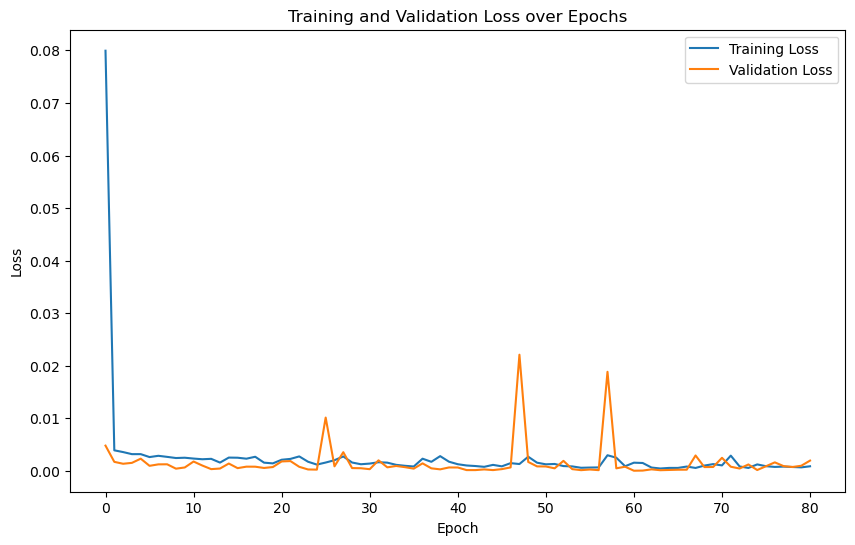

In [20]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_barlow_twins_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_barlow_twins_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [21]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.inner_model(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.inner_model(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [22]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.9994087038789026
Weighted F1 Score: 0.9994029595903329
Macro F1 Score: 0.9728071147572798
Random Guess Accuracy: 0.4721198844214674
                                        precision    recall  f1-score   support

                             astrocyte       1.00      1.00      1.00       567
     central nervous system macrophage       1.00      1.00      1.00       266
                      endothelial cell       1.00      1.00      1.00        28
                        ependymal cell       1.00      1.00      1.00        13
                            fibroblast       1.00      1.00      1.00        14
                             leukocyte       1.00      1.00      1.00         7
                                neuron       1.00      1.00      1.00      5486
                       oligodendrocyte       1.00      1.00      1.00      1786
        oligodendrocyte precursor cell       0.99      1.00      0.99       281
                              pericyte

In [23]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "HiT_CA4_DGC_barlow_twins_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicro_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['HiT_CA4_DGC'],
    'method': [re.search(r'HiT_CA4_DGC_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micro_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micro_f1
0.080	0.005	61	0.000	0.973	0.999	0.999
